**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/06/2023 <br>

#### Summary 

1. Introdution
<br></br>
1. Survival Analysis
<br></br>
   1. Kaplan-Meier Curve
<br></br>
   1. Log Rank Test
<br></br>
1. Modeling
<br></br>
1. Evaluation
<br></br>
1. Conclusion
<br></br>

<h2> Introduction

As said before, travel packages have a wide variety of valid periods and flexible cancellation policies. And understanding the Survival Time of a purchase can help financial and commercial planning. The time to a event we are interested in is the time to cancel a order after the purchase.

We'll try to identify the time of cancellation after a purchase through Survival Time Analysis. For this, the following statements will be considered:
- the start time is the moment of the order;
- the event time is the time of the last status change for canceled orders;
- the time to the event is the time_to_cancel_days feature; 

If the order was not canceled, then the case will be considered Censored Data.
<br></br>

<br></br>
<h2> Setup

In [1]:
import os

path = os.getcwd()
# os.chdir(os.path.join('..', path))
os.chdir('/home/tamiris/Documentos/Work/2022/survival_analysis/survival_analysis')

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import calibration_curve
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import src.visualization.visualization_utils as visuals

%matplotlib inline
%load_ext autoreload
%autoreload 2

set_config(display="text")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<br></br>
<h3> Load Data

In [3]:
df = pd.read_csv(f'src/data/package_data_processed.csv')

In [4]:
df = df[['qty_status_changes', 'destination_city', 'time_to_cancel_days', 'operation_started', 'time_to_cancel_months', 'destination_country', 'accommodation_type', 'qty_dailies', 'last_fill_to_cancel_days', 'order_canceled']]

In [5]:
df.head()

qty_status_changes  destination_city  time_to_cancel_days   
0                   1                 0                    0  \
1                   1               111                    0   
2                   1               155                    0   
3                   3               166                  583   
4                   1               177                    0   

   operation_started  time_to_cancel_months  destination_country   
0                  1                      0                    0  \
1                  1                      0                    0   
2                  1                      0                    0   
3                  0                     19                    0   
4                  1                      0                   11   

   accommodation_type  qty_dailies  last_fill_to_cancel_days  order_canceled  
0                   0            5                         0               0  
1                   0            5                         0               0  
2                   1            6                         0               0  
3                   0            4                       583               1  
4                   0            6                         0               0

<br></br>
<h2> Data Preparation

We'll truncate the dataset to 
- minimize the impact of data which we can consider as outliers
- to remove negative time interval
- to remove cases cancelled in 0 days

We'll consider outliers the cases above the upper limit of the following boxplot, with time_to_cancel bigger than 750 days.

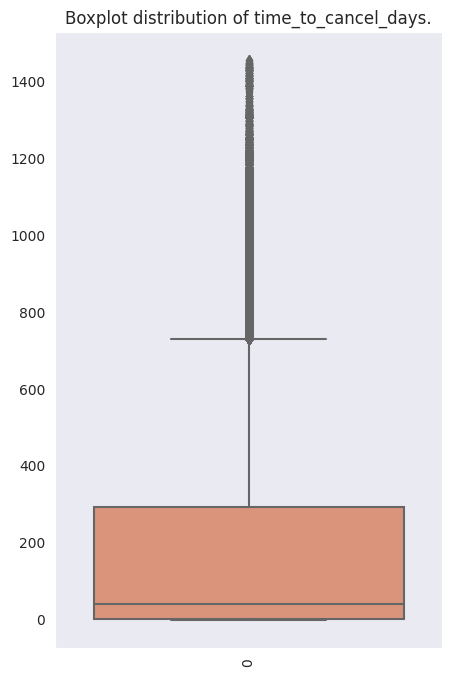

In [6]:
visuals.single_boxplot(df, 'time_to_cancel_days')

We'll also remove negative values and the cases with zero days to cancel.

In [7]:
df.time_to_cancel_days.sort_values().head(20)

213860   -1
502564   -1
393229   -1
456479   -1
439919   -1
480383   -1
476998   -1
827115   -1
28991    -1
450306   -1
398034   -1
39907    -1
375919   -1
5338     -1
401634   -1
536898    0
536891    0
536892    0
536909    0
536904    0
Name: time_to_cancel_days, dtype: int64

In [8]:
df = df.loc[(df.time_to_cancel_days > 0) & (df.time_to_cancel_days < 750)]

<br></br>
<h2> Survival Analysis


<h4> Kaplan-Meier Curve

Let's see the graphic representation of the survival rate for time_to_cancel_days using the Kaplan-Meier (KM) curve.

From the curve below, it's possible to notice that at least 60% of the orders survives after one year (365 days). The median survival time is 436 days, almost 1.2 years.

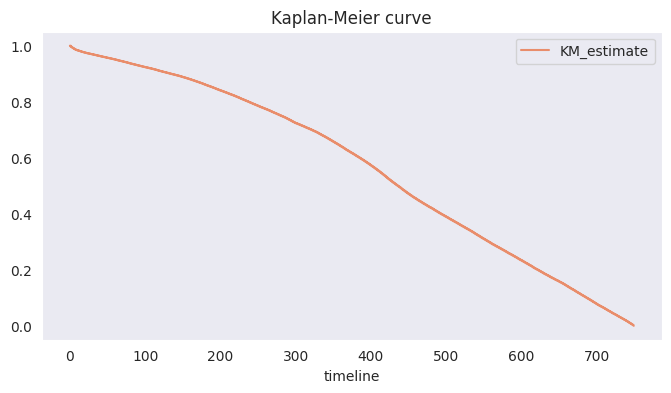

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(df['time_to_cancel_days'], df['order_canceled'])

plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve");

In [10]:
print(f'Median survival time is {kmf.median_survival_time_}')

Median survival time is 436.0


In the previous EDA we verified that the feature `operation_started` is the second most important feature impacting package cancellation. So let's fit and plot KM curves considering this feature.

The curve related to the cases which had the operation started clearly has a bigger median survival time than the other one. With 400 days, less than 40% of the cases which not had the operation started survived. In contrast, almost 80% of the cases with started operations had survived after 400 days.

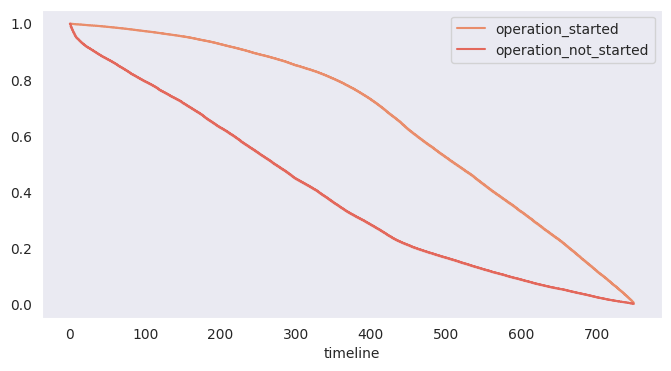

In [11]:
kmf_op = KaplanMeierFitter()
kmf_op_ns = KaplanMeierFitter()

plt.figure(figsize=(8,4))

kmf_op.fit(df.loc[df.operation_started == 1]['time_to_cancel_days'], df.loc[df.operation_started == 1]['order_canceled'], label ='operation_started')
ax = kmf_op.plot()

kmf_op_ns.fit(df.loc[df.operation_started == 0]['time_to_cancel_days'], df.loc[df.operation_started == 0]['order_canceled'], label ='operation_not_started')
kmf_op_ns.plot(ax=ax);

In [12]:
print(f'Median survival time for started operations is {kmf_op.median_survival_time_}')
print(f'Median survival time for not started operations is {kmf_op_ns.median_survival_time_}')

Median survival time for started operations is 512.0
Median survival time for not started operations is 272.0


<h4> Log Rank Test

The Log Rank Test is useful to compare two curves and verify if the groups represented by each curve are similar related to the surviving process.

We're going to use the Long Rank Test to verify the null hypothesis that 'operation started' and 'operation not started' survival curves are statistically equivalent:
- Null hypothesis: the curves are statistically equivalent (p_value > 0.05);
- Alternative hypothesis: the curves are not statistically equivalent.

The p_value < 0.005 indicates that we can reject the null hypothesis, which means that the survival functions are not statistically equivalent. I.e. the groups 'operation started' and 'operation not started' are nos equivalent in the surviving process.

In [13]:
results = logrank_test(
    df.loc[df.operation_started == 1]['time_to_cancel_months'], 
    df.loc[df.operation_started == 0]['time_to_cancel_months'], 
    event_observed_a = df.loc[df.operation_started == 1]['order_canceled'], 
    event_observed_b = df.loc[df.operation_started == 0]['order_canceled']
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
  event_observed_a = 11        1
14        1
15        1
21        0
22        0
         ..
967428    0
967430    1
967431    0
967434    0
967435    0
Name: order_canceled, Length: 351398, dtype: int64
  event_observed_b = 3         1
9         1
10        1
18        1
26        1
         ..
967386    1
967392    1
967395    1
967410    1
967433    1
Name: order_canceled, Length: 136108, dtype: int64
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2660.97 <0.005       inf

<br></br>
<h2> Modeling

We're going to sample the dataset to prevent from kernel crashing. The dataset is sufficiently balanced, so we'll generate a random stratified sample:

In [14]:
df.order_canceled.value_counts()

order_canceled
0    257032
1    230474
Name: count, dtype: int64

In [15]:
df.shape

(487506, 10)

In [51]:
df_samp = df.groupby('order_canceled', group_keys=False).apply(lambda x: x.sample(10000))
df_samp.shape

(20000, 10)

We'll evaluate two models:
- Random Survival Forest
- Gradient Boosting Survival Analysis

We'll consider the 'time_to_cancel_days' as the time to the event, and 'order_canceled' is the event occurrence.

In [18]:
df_samp['order_canceled'] = df_samp['order_canceled'].astype(bool) 

X = df_samp.drop(['order_canceled', 'time_to_cancel_months', 'time_to_cancel_days'], axis=1)
y = df_samp[['order_canceled', 'time_to_cancel_days']]

Splitting the data into train and test datasets:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

Now let's define the parameters, and it's range of values, for each of the models we'll train. The parameters will be used to perform GridSearchCV:

In [20]:
cases = {
    'rsf': {'model': RandomSurvivalForest, 'params': {'n_estimators': [10, 50, 100], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [5, 10]},}, 
    'gb': {'model': GradientBoostingSurvivalAnalysis, 'params': {'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.01, 0.001]}}
}

In [22]:
models = []

for key, values in cases.items():
    globals()[f'{key}_model'] = GridSearchCV(values['model'](random_state=42), values['params'], cv=5, verbose=1.1)
    models.append(globals()[f'{key}_model'])

In [52]:
models

[GridSearchCV(cv=5, estimator=RandomSurvivalForest(random_state=42),
              param_grid={'min_samples_leaf': [5, 10],
                          'min_samples_split': [2, 4, 6],
                          'n_estimators': [10, 50, 100]},
              verbose=1.1),
 GridSearchCV(cv=5, estimator=GradientBoostingSurvivalAnalysis(random_state=42),
              param_grid={'learning_rate': [0.1, 0.01, 0.001],
                          'n_estimators': [10, 50, 100]},
              verbose=1.1)]

Fitting the models:

In [23]:
for model in models:
    print(f'Fitting the model {model}...')
    model.fit(X_train, y_train.to_records(index=False))
    print('Completed.')
    print()

Fitting the model GridSearchCV(cv=5, estimator=RandomSurvivalForest(random_state=42),
             param_grid={'min_samples_leaf': [5, 10],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [10, 50, 100]},
             verbose=1.1)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   4.4s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   3.5s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   4.1s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   3.7s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   4.1s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=  22.7s
[CV] END min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=  21.2s
[CV] END min_samples_leaf=5, min_samples_split=2, n_es

Performing the inferences:

In [46]:
rsf_score = concordance_index_censored(y_test['order_canceled'], y_test['time_to_cancel_days'], models[0].predict(X_test))
gb_score = concordance_index_censored(y_test['order_canceled'], y_test['time_to_cancel_days'], models[1].predict(X_test))

To evaluate and compare the models, we'll use the Concordance Index (C-index), which measures the model's ability to rank subjects according to their survival times.

According to the values below we can attest that the Gradient Boosting Survival Analysis performed better than the Random Survival Forest.

In [47]:
print("Random Survival Forest C-index:", rsf_score[0])
print("Gradient Boosting Survival Analysis C-index:", gb_score[0])

Random Survival Forest C-index: 0.884456088356325
Gradient Boosting Survival Analysis C-index: 0.9600492260292958
